# DIP Project - Scrabble Assistant

## Team: lena
### Shaurya Dewan - 2019101017
### Chirag Sahu - 2019102006
### Harshwardhan Prasad - 2019102021
### Shivanshu Jain - 2019101001

## Preprocessing

### Importing Libraries

In [1]:
import os
from copy import copy, deepcopy
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import timeit

In [2]:
def display(imgs, titles, gray, size=(10, 10), rows=1):
    fig = plt.figure(figsize=size)
    
    for i in range(len(imgs)):
        fig.add_subplot(rows, len(imgs) // rows, i + 1)
        if gray[i]:
            plt.imshow(imgs[i], cmap='gray')
        else:
            plt.imshow(imgs[i])

        plt.title(titles[i])

### Grayscale Conversion

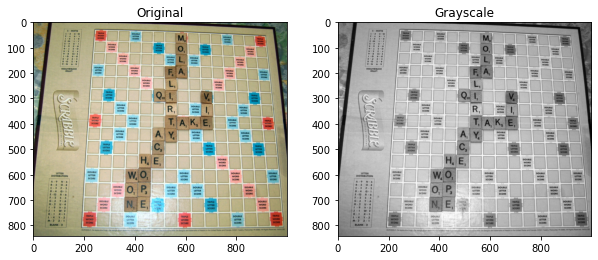

In [3]:
def rgb2Gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

img = cv2.imread('../data/board1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = rgb2Gray(img)
display([img, gray], ['Original', 'Grayscale'], [0, 1])

### Adaptive Histogram Equalization

We first compared regular histogram equalization with the adaptive version to check how different are the results. Then we tried various parameters for the adaptive version to find the optimal one. We found that a clip size of 5 and a tile/block size of 11x11 seemed to give the best results.

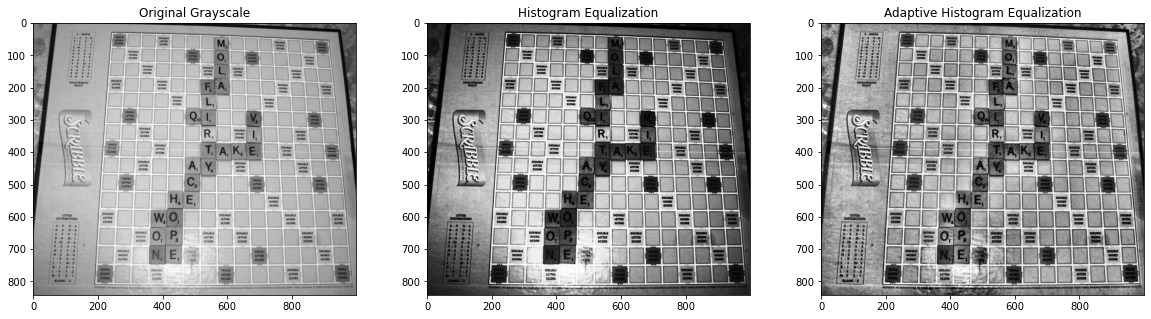

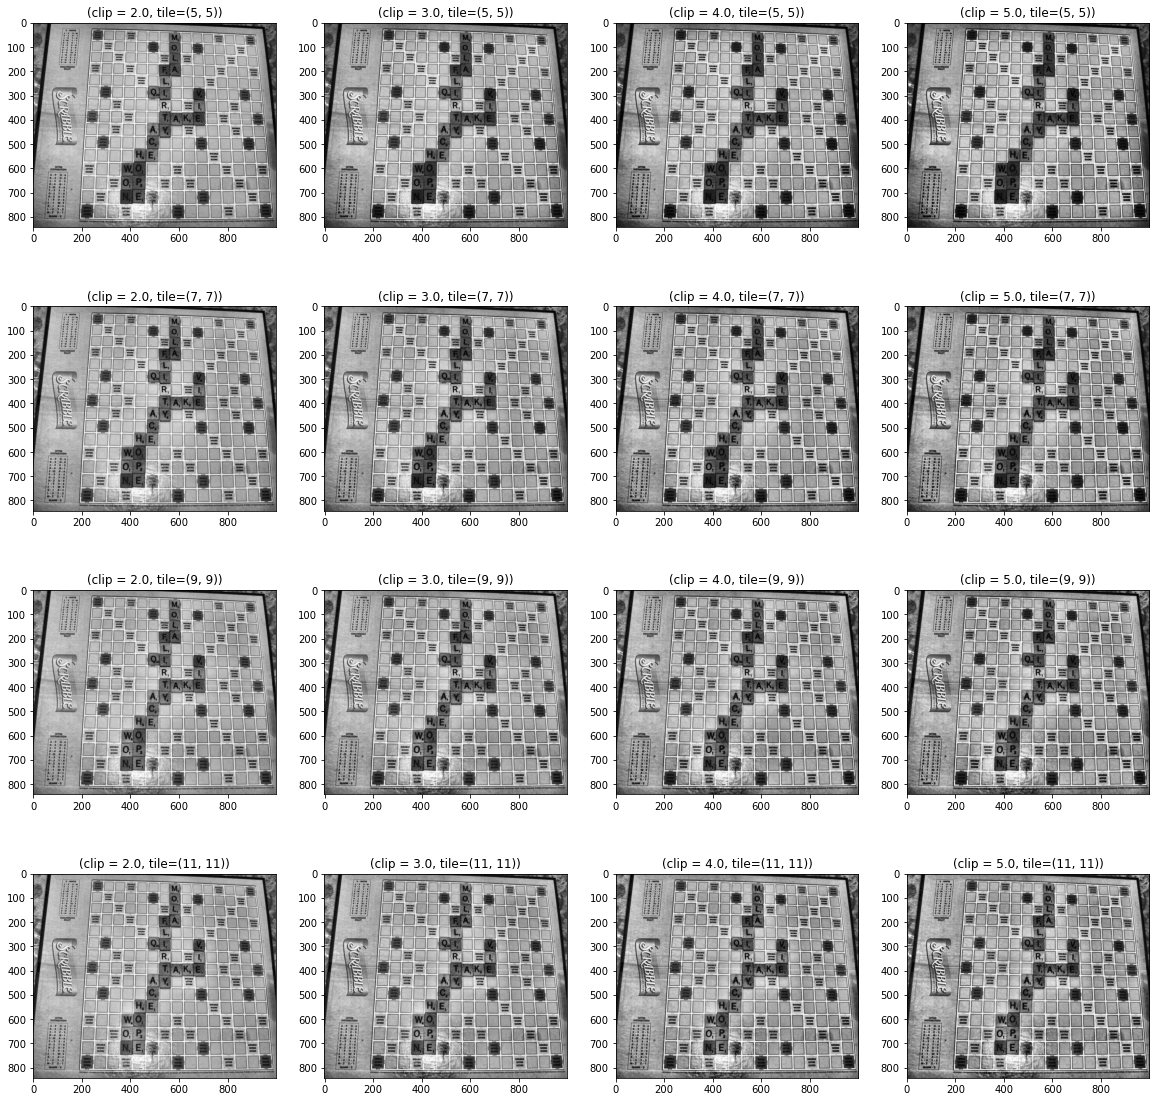

In [4]:
def adaptiveHistEq(img, clipLimit=5, tileGridSize=(11, 11)):
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    return clahe.apply(gray)

imgArr = []
titleArr = []

for i in range(5, 13, 2):
    for j in np.arange(2, 5.5, 1):
        adaptHist = adaptiveHistEq(gray, j, (i, i))
        imgArr.append(adaptHist)
        titleArr.append('(clip = {}, tile={})'.format(j, (i, i)))

hist = cv2.equalizeHist(gray)
adaptHist = adaptiveHistEq(gray)
display([gray, hist, adaptHist], ['Original Grayscale', 'Histogram Equalization', 'Adaptive Histogram Equalization'], [1] * 3, (20, 5))

display(imgArr, titleArr, [1] * len(imgArr), (20, 20), rows = len(imgArr) // 4)

### Tile Size Detection

This is done in order to normalize the image size in the next step. We obtain the empty boxes/tiles using the MSERs that satisfy certain conditions and use the median of these tiles widths' to estimate the tile size.

Current Tile Size =  40.0


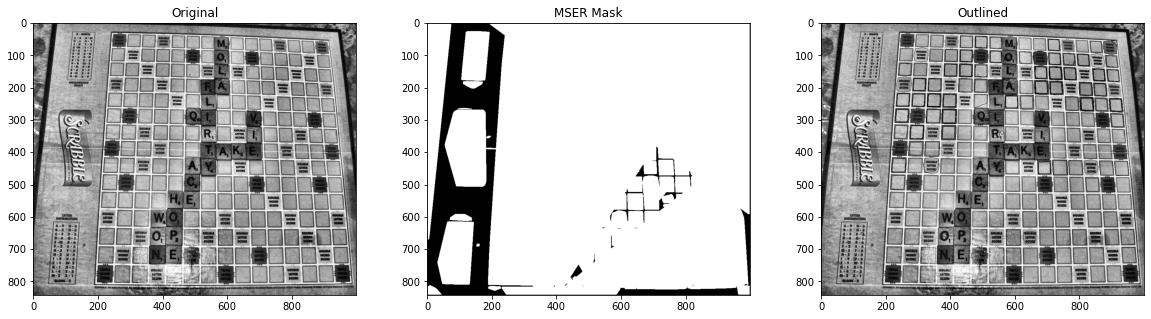

In [5]:
def getMsers(img, tol=0.001):
    maxArea = img.shape[0] * img.shape[1] / 225
    mser = cv2.MSER_create()
    regions, boundingBoxes = mser.detectRegions(img)
    hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]

    mask = np.zeros((img.shape[0], img.shape[1], 1), dtype=np.uint8)
    smallHulls = []
    widths = []
    for contour in hulls:
        width = np.max(contour[:, 0, 1]) - np.min(contour[:, 0, 1])
        height = np.max(contour[:, 0, 0]) - np.min(contour[:, 0, 0])
        area = width * height
        
        if area >= 100 and area <= maxArea and abs(width - height) <= tol * max(width, height):
            smallHulls.append(contour)
            widths.append(width)

        cv2.drawContours(mask, [contour], -1, (255, 255, 255), -1)

    tileSize = np.median(np.array(widths))
    outline = deepcopy(img)
    cv2.polylines(outline, smallHulls, 1, (0, 255, 0))
    return tileSize, mask, outline, smallHulls

tileSize, mask, outline, smallHulls = getMsers(adaptHist)
print('Current Tile Size = ', tileSize)
display([adaptHist, mask, outline], ['Original', 'MSER Mask', 'Outlined'], [1] * 3, (20, 5))

### Resizing

This is done to normalize the image size such that the tiles width is approximately 30 pixels.

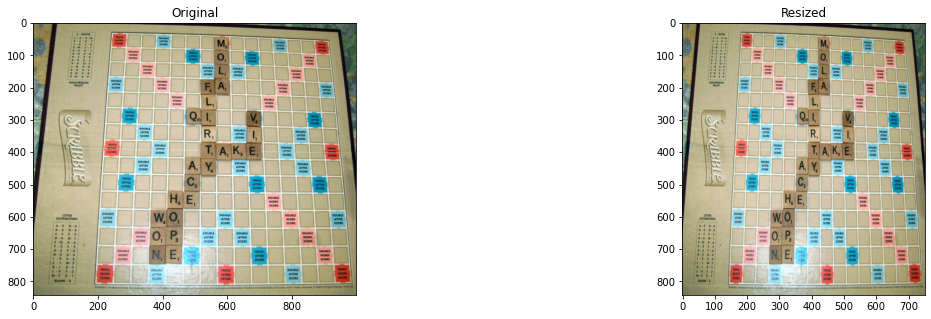

In [6]:
def resizeImg(img, percent):
    width = int(img.shape[1] * percent[0])
    height = int(img.shape[0] * percent[1])
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

resized = resizeImg(img, [30 / tileSize, 1])
display([img, resized], ['Original', 'Resized'], [1, 1], (20, 5))

## Grid Detection

### Grid Outline Detection

Here we obtain the outline/border of the overall main grid.

In [7]:
def border(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    blur = cv2.GaussianBlur(gray, (7, 7), 0)
    edges = cv2.Canny(blur, 50, 100, apertureSize=3)
    kernel = np.ones((5, 5), np.uint8)
    dilation = cv2.dilate(edges, kernel, iterations=2)
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(contours, key=cv2.contourArea)
    contour_img = img.copy()
    contour_img = cv2.drawContours(contour_img, [cnt], 0, (0, 255, 0), 3)
    epsilon = 0.01 * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    x_center = np.mean(approx[:, :, 0])
    y_center = np.mean(approx[:, :, 1])

    pts = np.zeros((4, 2))
    for x in approx:
        for X, Y in x:
            if X < x_center and Y < y_center:
                pts[0, 0] = X
                pts[0, 1] = Y
            if X < x_center and Y > y_center:
                pts[1, 0] = X
                pts[1, 1] = Y
            if X > x_center and Y > y_center:
                pts[2, 0] = X
                pts[2, 1] = Y
            if X > x_center and Y < y_center:
                pts[3, 0] = X
                pts[3, 1] = Y
                
    size = max(approx.flatten()) - min(approx.flatten()) 
    return contour_img, pts, size

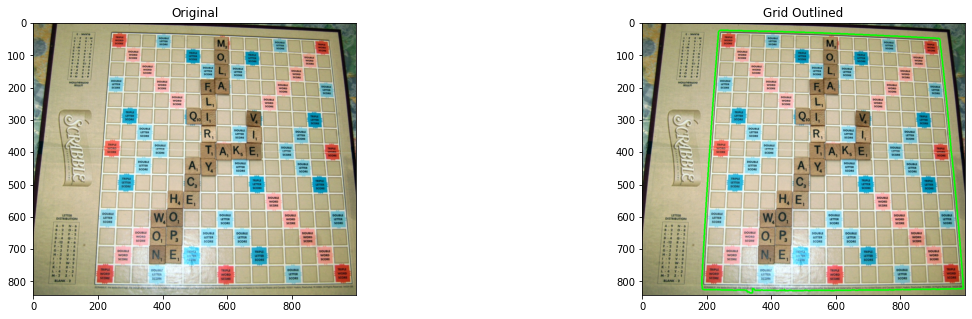

In [8]:
contourImg, pts, size = border(img)
display([img, contourImg], ['Original', 'Grid Outlined'], [0, 0], (20, 5))

### Skew Correction

We crop the image and rotate it so that the grid covers the entire image and the background is removed.

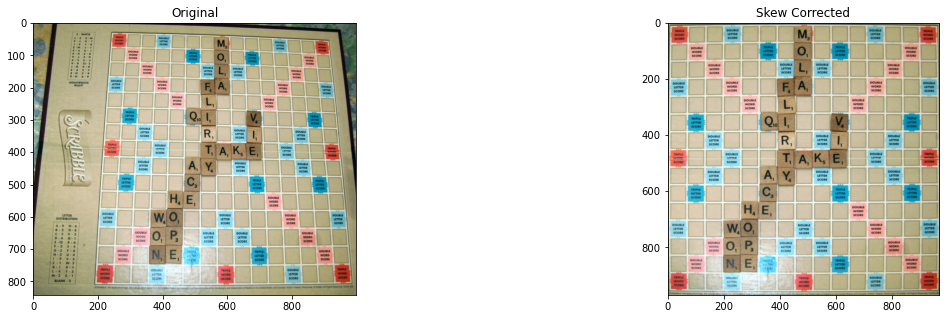

In [9]:
def transform(img, pts, size): 
    pts = np.float32(pts)
    pts_sqr = np.float32([[0, 0], [0, size], [size, size], [size, 0]])
    M = cv2.getPerspectiveTransform(pts, pts_sqr)
    warped_img = cv2.warpPerspective(img, M, (size, size))
    return warped_img

warpedImg = transform(img, pts, size)
display([img, warpedImg], ['Original', 'Skew Corrected'], [0, 0], (20, 5))

### Grid Fitting

In [10]:
def gammaTransform(im, gamma):
    im = im.astype(float)
    im = im / 255
    im = np.power(im, gamma)
    im = im * 255
    im = im.astype(np.uint8)

    return im

In [11]:
def gridFitting(img):
    gray = rgb2Gray(img)
    roughtFit = deepcopy(img)
    divs = 15
    
    for i in range(divs + 1):
        roughFit = cv2.line(roughtFit, (0, i * img.shape[1] // divs), (img.shape[0], i * img.shape[1] // divs), (0, 0, 255), 2)
        
    for i in range(divs + 1):
        roughFit = cv2.line(roughtFit, (i * img.shape[0] // divs, 0), (i * img.shape[0] // divs, img.shape[1]), (0, 0, 255), 2)

    mserFit = np.zeros(img.shape)
    bright = gammaTransform(gray, 0.5)
    _, _, _, msersEmpty = getMsers(bright)
    dark = gammaTransform(gray, 1.5)
    _, _, _, msersFill = getMsers(dark, 0.05)

    msers = msersEmpty + msersFill
    cv2.polylines(roughFit, msers, 1, (0, 255, 0))
    kernel = np.zeros((7, 7), np.uint8)
    roughFit = cv2.erode(roughFit, kernel, iterations=1)
    
    mids = []
    for i in range(len(msers)):
        mser = msers[i]
        midR = (np.max(mser[:, 0, 0]) + np.min(mser[:, 0, 0])) // 2
        midC = (np.max(mser[:, 0, 1]) + np.min(mser[:, 0, 1])) // 2
        mids.append([midR, midC])
    
    mids = np.array(mids)
    gridAllot = [-1] * len(msers)
    for i in range(divs):
        minR = i * img.shape[0] // divs
        maxR = (i + 1) * img.shape[0] // divs
        
        for j in range(divs):
            minC = j * img.shape[1] // divs
            maxC = (j + 1) * img.shape[1] // divs
            
            for k in range(len(mids)):
                if mids[k][0] in range(minR, maxR) and mids[k][1] in range(minC, maxC):
                    gridAllot[k] = 15 * i + j
            
    gridAllot = np.array(gridAllot)
    finalFit = deepcopy(img)
    for i in range(divs - 1):
        col = (i + 1) * img.shape[1] // divs
        multiples = np.arange(i, divs ** 2, divs)
        st = set(multiples)
        leftMidInds = [i for i, e in enumerate(gridAllot) if e in st]
        leftMids = mids[leftMidInds, 1]
        
        multiples = np.arange(i + 1, divs ** 2, divs)
        st = set(multiples)
        rightMidInds = [i for i, e in enumerate(gridAllot) if e in st]
        rightMids = mids[rightMidInds, 1]
        
        if len(leftMids) and len(rightMids):
            col = int((np.mean(leftMids) + np.mean(rightMids)) // 2)
        
        finalFit = cv2.line(finalFit, (col, 0), (col, img.shape[0]), (0, 0, 255), 2)
       
    for i in range(divs - 1):
        row = (i + 1) * img.shape[0] // divs
        multiples = np.arange(divs * i, divs * i + divs, 1)
        st = set(multiples)
        leftMidInds = [i for i, e in enumerate(gridAllot) if e in st]
        leftMids = mids[leftMidInds, 0]
        
        multiples = np.arange(divs * (i + 1), divs * (i + 1) + divs, 1)
        st = set(multiples)
        rightMidInds = [i for i, e in enumerate(gridAllot) if e in st]
        rightMids = mids[rightMidInds, 0]
        
        if len(leftMids) and len(rightMids):
            row = int((np.mean(leftMids) + np.mean(rightMids)) // 2)
            
        finalFit = cv2.line(finalFit, (0, row), (img.shape[1], row), (0, 0, 255), 2)
            
    return roughFit, finalFit

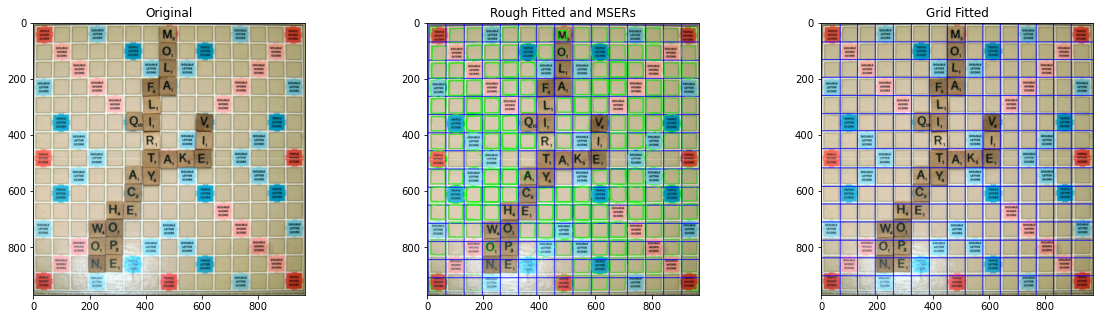

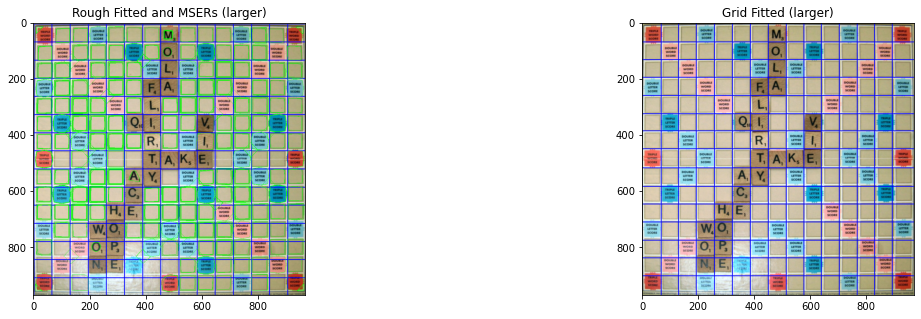

In [12]:
roughImg, fittedImg = gridFitting(warpedImg)
display([warpedImg, roughImg, fittedImg], ['Original', 'Rough Fitted and MSERs', 'Grid Fitted'], [0] * 3, (20, 5))
display([roughImg, fittedImg], ['Rough Fitted and MSERs (larger)', 'Grid Fitted (larger)'], [0] * 2, (20, 5))

## Character Extraction

### Character Detection

In [13]:
def charDetection(img):
    gray = rgb2Gray(img)
    edges = cv2.Canny(gray, 50, 200, apertureSize=3)
    _, mask, _, msers = getMsers(gray)
    enhancedMask = deepcopy(mask)
    
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i][j] and edges[i][j]:
                enhancedMask[i][j] = 0
            else:
                enhancedMask[i][j] = 255

    _, mask2, _, msers2 = getMsers(enhancedMask)
    return mask, enhancedMask

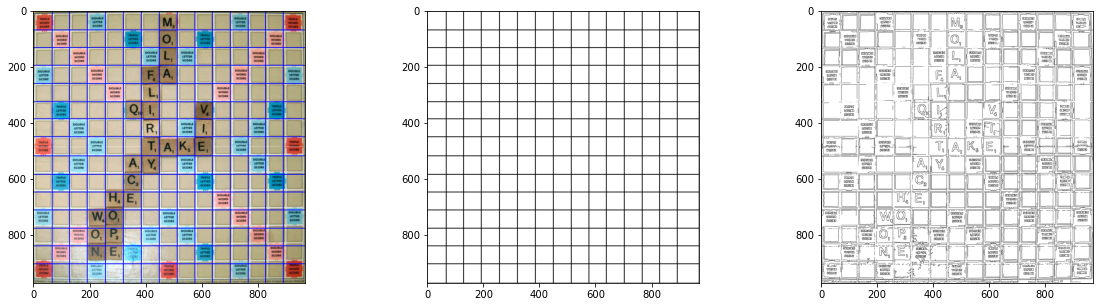

In [14]:
img1, img2 = charDetection(fittedImg)
display([fittedImg, img1, img2], ['', '', ''], (0, 1, 1), (20, 5))